In [45]:
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint
from workalendar.asia import hong_kong
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from xgboost import XGBClassifier, XGBRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [46]:
price_col_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Open(t+1)', 'Open(t+1) >= Close', 'Volume']

In [47]:
bert_df = pd.read_csv('bert_output20171001-20200430_v1.gzip', compression='gzip', index_col='title')
pca = PCA(n_components=.98)
pca.fit(bert_df)
print('number of pca columns:', pca.n_components_)
pca_cols = ['bert_pca{}'.format(1+i) for i in range(pca.n_components_)]
bert_pca_df = pd.DataFrame(pca.transform(bert_df), index=bert_df.index, columns=pca_cols)

number of pca columns: 10


In [48]:
news_df = pd.read_csv('data/news_20171001-20200430.gzip', compression='gzip', usecols=['title', 'date']) #for mapping

sentiment_df = pd.read_csv('normalised_sentiment_analysis.csv', usecols=['title_pos', 'desc_pos', 'content_pos'])

sentiment_df['sum_mean'] = (sentiment_df['title_pos'] + sentiment_df['desc_pos'] + sentiment_df['content_pos'])

sentiment_cols = sentiment_df.columns.tolist()

news_df_merged = pd.concat([news_df, sentiment_df], axis=1)

news_df_merged = news_df_merged.set_index('title').merge(bert_pca_df, left_index=True, right_index=True, how='left')

news_df_merged_groupby_mean = news_df_merged.groupby('date')[pca_cols+sentiment_cols].agg(['mean'])

news_df_merged_groupby_sum = news_df_merged.groupby('date')[sentiment_cols].agg(['sum'])

news_df_merged_groupby = news_df_merged_groupby_mean.merge(news_df_merged_groupby_sum, left_index=True, right_index=True)

news_df_merged_groupby.columns = ['_'.join(col) for col in news_df_merged_groupby.columns]

news_df_merged_groupby['news_count'] = news_df_merged['date'].value_counts()

In [49]:
news_df_merged_groupby.head()

,bert_pca1_mean,bert_pca2_mean,bert_pca3_mean,bert_pca4_mean,bert_pca5_mean,bert_pca6_mean,bert_pca7_mean,bert_pca8_mean,bert_pca9_mean,bert_pca10_mean,title_pos_mean,desc_pos_mean,content_pos_mean,sum_mean_mean,title_pos_sum,desc_pos_sum,content_pos_sum,sum_mean_sum,news_count
date,,,,,,,,,,,,,,,,,,,
2017-11-08,-1.133180,0.364787,0.119353,0.052549,0.143237,-0.115315,-0.140967,-0.044298,-0.100485,0.016016,0.125000,0.333333,0.333333,0.791667,0.250000,0.666667,0.666667,1.583333,2
2017-11-09,-1.503109,0.435174,0.041264,0.038034,-0.045575,-0.010922,0.011972,-0.082301,-0.102096,0.041474,0.190476,0.285714,0.321429,0.797619,0.761905,1.142857,1.285714,3.190476,4
2017-11-10,-0.299249,-0.377338,-0.256372,-0.116277,-0.075168,0.144589,-0.018752,0.075183,0.019416,-0.043594,0.264172,0.278912,0.317007,0.860091,1.849206,1.952381,2.219048,6.020635,7
2017-11-11,-0.666879,0.034862,0.071422,-0.071578,0.039350,0.014666,-0.079183,-0.075110,-0.084971,0.089689,0.246561,0.275000,0.333333,0.854894,0.986243,1.100000,1.333333,3.419577,4
2017-11-12,-0.083503,-0.379441,0.014269,-0.412953,0.022082,-0.011763,-0.055076,-0.001970,-0.098344,-0.016397,0.250000,0.255556,0.333333,0.838889,1.250000,1.277778,1.666667,4.194444,5


In [50]:
#create holiday date columns and mapping

cal = hong_kong.HongKong()

holiday_list = [str(day[0]) for day in cal.holidays(2018)+cal.holidays(2019)+cal.holidays(2020)]

news_df_merged_groupby['holiday'] = np.where(news_df_merged_groupby.index.isin(holiday_list), 1, 0)

price_700_df = pd.read_csv('data/price_20171001-20200430.gzip', compression='gzip', index_col='Date')
price_700_df['date'] = price_700_df.index

news_df_merged_groupby2 = news_df_merged_groupby.merge(price_700_df[['date']], 
                                                       left_index=True, 
                                                       right_index=True, 
                                                       how='left')

In [51]:
news_df_merged_groupby2.head()

,bert_pca1_mean,bert_pca2_mean,bert_pca3_mean,bert_pca4_mean,bert_pca5_mean,bert_pca6_mean,bert_pca7_mean,bert_pca8_mean,bert_pca9_mean,bert_pca10_mean,...,desc_pos_mean,content_pos_mean,sum_mean_mean,title_pos_sum,desc_pos_sum,content_pos_sum,sum_mean_sum,news_count,holiday,date
date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,-1.133180,0.364787,0.119353,0.052549,0.143237,-0.115315,-0.140967,-0.044298,-0.100485,0.016016,...,0.333333,0.333333,0.791667,0.250000,0.666667,0.666667,1.583333,2,0,2017-11-08
2017-11-09,-1.503109,0.435174,0.041264,0.038034,-0.045575,-0.010922,0.011972,-0.082301,-0.102096,0.041474,...,0.285714,0.321429,0.797619,0.761905,1.142857,1.285714,3.190476,4,0,2017-11-09
2017-11-10,-0.299249,-0.377338,-0.256372,-0.116277,-0.075168,0.144589,-0.018752,0.075183,0.019416,-0.043594,...,0.278912,0.317007,0.860091,1.849206,1.952381,2.219048,6.020635,7,0,2017-11-10
2017-11-11,-0.666879,0.034862,0.071422,-0.071578,0.039350,0.014666,-0.079183,-0.075110,-0.084971,0.089689,...,0.275000,0.333333,0.854894,0.986243,1.100000,1.333333,3.419577,4,0,NaN
2017-11-12,-0.083503,-0.379441,0.014269,-0.412953,0.022082,-0.011763,-0.055076,-0.001970,-0.098344,-0.016397,...,0.255556,0.333333,0.838889,1.250000,1.277778,1.666667,4.194444,5,0,NaN


In [52]:
#fill the Sat, Sun and holiday for mapping

t = 1
while news_df_merged_groupby2['date'].isnull().any():
    news_df_merged_groupby2['date'] = news_df_merged_groupby2['date'].fillna(
        news_df_merged_groupby2['date'].shift(t))
    
    t += 1
    
news_df_merged_groupby3 = news_df_merged_groupby2.groupby(news_df_merged_groupby2['date'])[
    news_df_merged_groupby.columns.tolist()].sum()

price_700_df_merged = price_700_df.merge(news_df_merged_groupby3, left_index=True, right_index=True)

In [53]:
price_700_df_merged.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,title_pos_mean,desc_pos_mean,content_pos_mean,sum_mean_mean,title_pos_sum,desc_pos_sum,content_pos_sum,sum_mean_sum,news_count,holiday
2017-11-08,387.200012,398.600006,382.399994,385.600006,383.721924,43983824,5.235018e+07,88834069,0.104774,6.011343e+07,...,0.125000,0.333333,0.333333,0.791667,0.250000,0.666667,0.666667,1.583333,2,0
2017-11-09,385.200012,392.399994,385.200012,387.799988,385.911194,23906595,4.570934e+07,112740664,0.124267,5.903923e+07,...,0.190476,0.285714,0.321429,0.797619,0.761905,1.142857,1.285714,3.190476,4,0
2017-11-10,383.399994,390.799988,383.399994,385.399994,383.522888,17152006,3.782870e+07,95588658,0.077449,4.472438e+07,...,0.760733,0.809467,0.983673,2.553874,4.085450,4.330159,5.219048,13.634656,16,0
2017-11-13,385.000000,392.000000,385.000000,387.600006,385.712189,17666194,3.328600e+07,113254852,0.017639,4.388745e+07,...,0.264323,0.313591,0.300779,0.878693,1.850261,2.195138,2.105450,6.150849,7,0
2017-11-14,394.000000,394.000000,387.399994,388.000000,386.110229,20492898,1.651911e+07,133747750,-0.029111,3.878882e+07,...,0.264263,0.277959,0.310705,0.852927,1.321314,1.389797,1.553526,4.264637,5,0


In [54]:
#shift the columns

shift_col_list = [col for col in price_700_df_merged.columns if col not in price_col_list+['date', 'holiday']]
shift_number = 4

for t in range(shift_number):
    price_700_df_merged[[col+'(t-{})'.format(t+1) for col in shift_col_list]] = price_700_df_merged[
        shift_col_list].shift(t+1)
    
price_700_df_merged = price_700_df_merged.iloc[shift_number:, ]

In [55]:
price_700_df_merged.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,bert_pca10_mean(t-4),title_pos_mean(t-4),desc_pos_mean(t-4),content_pos_mean(t-4),sum_mean_mean(t-4),title_pos_sum(t-4),desc_pos_sum(t-4),content_pos_sum(t-4),sum_mean_sum(t-4),news_count(t-4)
2017-11-14,394.000000,394.000000,387.399994,388.000000,386.110229,20492898,1.651911e+07,133747750,-0.029111,3.878882e+07,...,0.016016,0.125000,0.333333,0.333333,0.791667,0.250000,0.666667,0.666667,1.583333,2.0
2017-11-15,383.799988,388.000000,383.000000,383.000000,381.134583,23436345,-6.917232e+06,110311405,-0.116871,1.650731e+07,...,0.041474,0.190476,0.285714,0.321429,0.797619,0.761905,1.142857,1.285714,3.190476,4.0
2017-11-16,388.200012,393.799988,384.000000,391.799988,389.891693,32583706,1.236699e+07,142895111,-0.017458,5.511144e+07,...,0.029698,0.760733,0.809467,0.983673,2.553874,4.085450,4.330159,5.219048,13.634656,16.0
2017-11-17,397.000000,405.000000,397.000000,403.399994,401.435242,34542285,3.309230e+07,177437396,0.024822,1.044799e+08,...,0.164980,0.264323,0.313591,0.300779,0.878693,1.850261,2.195138,2.105450,6.150849,7.0
2017-11-20,405.399994,420.000000,405.399994,420.000000,417.954376,35231740,6.832404e+07,212669136,0.111815,1.731038e+08,...,0.025316,0.264263,0.277959,0.310705,0.852927,1.321314,1.389797,1.553526,4.264637,5.0


In [101]:
#create date related columns

price_700_df['date'] = pd.to_datetime(price_700_df.index, yearfirst=True)
price_700_df['month'] = price_700_df['date'].dt.month
price_700_df['day'] = price_700_df['date'].dt.day
price_700_df['weekday'] = price_700_df['date'].dt.weekday
# price_700_df_merged.head()

# X_train, X_test, y_train, y_test = train_test_split(price_700_df_merged.drop(price_col_list+['date'], axis=1)
    # , price_700_df_merged['Open(t+1) >= Close'], test_size=.2, random_state=1, stratify=price_700_df_merged['Open(t+1) >= Close'])

data_len = price_700_df_merged.shape[0]
X_train = price_700_df_merged.drop(price_col_list+['date'], axis=1).iloc[:9*data_len//10:, :]
X_test = price_700_df_merged.drop(price_col_list+['date'], axis=1).iloc[9*data_len//10:, :]
y_train = price_700_df_merged['Open(t+1) >= Close'].iloc[:9*data_len//10]
y_test = price_700_df_merged['Open(t+1) >= Close'].iloc[9*data_len//10:]


In [58]:
print(X_train.shape)

for col in X_train:
    if X_train[col].isnull().sum() > 0:
        print('missing is found in:', col)
print('target rate', y_train.mean())

(544, 481)
target rate 0.6213235294117647


In [153]:
random_state_model = 1
n_jobs = 15

xgbc = XGBClassifier(random_state=random_state_model, n_jobs=n_jobs, eval_set=[(X_train, y_train)], eval_metric='auc', early_stopping_rounds=5)

param_dist = {'n_estimator': randint(10, 15), 
              'max_depth': randint(1, 3), 
              'learning_rate': uniform(.005, .01), 
              'min_child_weight': uniform(.01, .1),
              'subsample': uniform(.3, .6), 
              'lambda': uniform(2, 3), #l2
              'alpha': uniform(1, 3)} #l1

rs_cv = RandomizedSearchCV(xgbc, param_dist, n_iter=20, return_train_score=True, n_jobs=n_jobs, scoring='roc_auc',
                           cv=StratifiedShuffleSplit(n_splits=3, test_size=.2, random_state=random_state_model))

rs_cv.fit(X_train, y_train)

cv_result = pd.DataFrame.from_dict(rs_cv.cv_results_).sort_values('rank_test_score', ascending=False)
print(cv_result[['mean_train_score', 'mean_test_score']])

importance_feature_df = pd.DataFrame({'col': X_train.columns, 
                                      'importance': rs_cv.best_estimator_.feature_importances_})

print(importance_feature_df.sort_values('importance', ascending=False).head(30))

print('roc_auc in train:', roc_auc_score(y_train, rs_cv.best_estimator_.predict_proba(X_train)[:,  1]))
print('roc_auc in test:', roc_auc_score(y_test, rs_cv.best_estimator_.predict_proba(X_test)[:, 1]))

    mean_train_score  mean_test_score
1           0.848219         0.751495
19          0.856203         0.761597
8           0.856251         0.767037
18          0.860741         0.768293
16          0.861586         0.777499
4           0.862147         0.777618
6           0.858264         0.779173
17          0.879267         0.783596
12          0.784837         0.787243
7           0.852959         0.788977
10          0.786248         0.790471
11          0.782204         0.790710
14          0.800509         0.790890
3           0.787860         0.791786
13          0.860105         0.793161
2           0.799933         0.793639
5           0.796409         0.793998
0           0.801811         0.794835
9           0.790007         0.795433
15          0.791796         0.797226
                            col  importance
75           sp500_index_change    0.289444
74          nasdaq_index_change    0.254685
76             dji_index_change    0.234991
371         bert_pca6_mean

## LSTM

X lstm train shape (535, 10, 103)
y lstm train shape (535,)
Train on 535 samples, validate on 60 samples
Epoch 1/500
 - 1s - loss: 0.6934 - accuracy: 0.5645 - val_loss: 0.6521 - val_accuracy: 0.6167
Epoch 2/500
 - 0s - loss: 0.6877 - accuracy: 0.6019 - val_loss: 0.6593 - val_accuracy: 0.6167
Epoch 3/500
 - 0s - loss: 0.6735 - accuracy: 0.6150 - val_loss: 0.6557 - val_accuracy: 0.6167
Epoch 4/500
 - 0s - loss: 0.6674 - accuracy: 0.6131 - val_loss: 0.6531 - val_accuracy: 0.6167
Epoch 5/500
 - 0s - loss: 0.6696 - accuracy: 0.6150 - val_loss: 0.6531 - val_accuracy: 0.6167
Epoch 6/500
 - 0s - loss: 0.6723 - accuracy: 0.6187 - val_loss: 0.6539 - val_accuracy: 0.6167
Epoch 7/500
 - 0s - loss: 0.6591 - accuracy: 0.6168 - val_loss: 0.6533 - val_accuracy: 0.6167
Epoch 8/500
 - 0s - loss: 0.6649 - accuracy: 0.6224 - val_loss: 0.6534 - val_accuracy: 0.6167
Epoch 9/500
 - 0s - loss: 0.6669 - accuracy: 0.6187 - val_loss: 0.6526 - val_accuracy: 0.6167
Epoch 10/500
 - 0s - loss: 0.6665 - accuracy: 0.6

Epoch 87/500
 - 0s - loss: 0.6560 - accuracy: 0.6150 - val_loss: 0.6473 - val_accuracy: 0.6167
Epoch 88/500
 - 0s - loss: 0.6590 - accuracy: 0.6187 - val_loss: 0.6482 - val_accuracy: 0.6167
Epoch 89/500
 - 0s - loss: 0.6563 - accuracy: 0.6243 - val_loss: 0.6478 - val_accuracy: 0.6167
Epoch 90/500
 - 0s - loss: 0.6597 - accuracy: 0.6187 - val_loss: 0.6493 - val_accuracy: 0.6167
Epoch 91/500
 - 0s - loss: 0.6617 - accuracy: 0.6168 - val_loss: 0.6491 - val_accuracy: 0.6167
Epoch 92/500
 - 0s - loss: 0.6547 - accuracy: 0.6243 - val_loss: 0.6493 - val_accuracy: 0.6167
Epoch 93/500
 - 0s - loss: 0.6569 - accuracy: 0.6262 - val_loss: 0.6507 - val_accuracy: 0.6167
Epoch 94/500
 - 0s - loss: 0.6553 - accuracy: 0.6150 - val_loss: 0.6512 - val_accuracy: 0.6167
Epoch 95/500
 - 0s - loss: 0.6639 - accuracy: 0.6150 - val_loss: 0.6514 - val_accuracy: 0.6167
Epoch 96/500
 - 0s - loss: 0.6514 - accuracy: 0.6206 - val_loss: 0.6513 - val_accuracy: 0.6167
Epoch 97/500
 - 0s - loss: 0.6514 - accuracy: 0.62

Epoch 173/500
 - 0s - loss: 0.6575 - accuracy: 0.6262 - val_loss: 0.6442 - val_accuracy: 0.6167
Epoch 174/500
 - 0s - loss: 0.6547 - accuracy: 0.6262 - val_loss: 0.6480 - val_accuracy: 0.6167
Epoch 175/500
 - 0s - loss: 0.6519 - accuracy: 0.6187 - val_loss: 0.6497 - val_accuracy: 0.6167
Epoch 176/500
 - 0s - loss: 0.6500 - accuracy: 0.6280 - val_loss: 0.6507 - val_accuracy: 0.6167
Epoch 177/500
 - 0s - loss: 0.6526 - accuracy: 0.6243 - val_loss: 0.6531 - val_accuracy: 0.6167
Epoch 178/500
 - 0s - loss: 0.6472 - accuracy: 0.6336 - val_loss: 0.6502 - val_accuracy: 0.6167
Epoch 179/500
 - 0s - loss: 0.6516 - accuracy: 0.6411 - val_loss: 0.6470 - val_accuracy: 0.6167
Epoch 180/500
 - 0s - loss: 0.6552 - accuracy: 0.6280 - val_loss: 0.6493 - val_accuracy: 0.6167
Epoch 181/500
 - 0s - loss: 0.6534 - accuracy: 0.6280 - val_loss: 0.6482 - val_accuracy: 0.6167
Epoch 182/500
 - 0s - loss: 0.6544 - accuracy: 0.6150 - val_loss: 0.6470 - val_accuracy: 0.6167
Epoch 183/500
 - 0s - loss: 0.6496 - acc

Epoch 259/500
 - 0s - loss: 0.6455 - accuracy: 0.6224 - val_loss: 0.6498 - val_accuracy: 0.6167
Epoch 260/500
 - 0s - loss: 0.6487 - accuracy: 0.6318 - val_loss: 0.6507 - val_accuracy: 0.6167
Epoch 261/500
 - 0s - loss: 0.6456 - accuracy: 0.6318 - val_loss: 0.6508 - val_accuracy: 0.6167
Epoch 262/500
 - 0s - loss: 0.6457 - accuracy: 0.6336 - val_loss: 0.6510 - val_accuracy: 0.6167
Epoch 263/500
 - 0s - loss: 0.6516 - accuracy: 0.6150 - val_loss: 0.6493 - val_accuracy: 0.6167
Epoch 264/500
 - 0s - loss: 0.6453 - accuracy: 0.6262 - val_loss: 0.6485 - val_accuracy: 0.6167
Epoch 265/500
 - 0s - loss: 0.6523 - accuracy: 0.6150 - val_loss: 0.6484 - val_accuracy: 0.6167
Epoch 266/500
 - 0s - loss: 0.6526 - accuracy: 0.6224 - val_loss: 0.6472 - val_accuracy: 0.6167
Epoch 267/500
 - 0s - loss: 0.6538 - accuracy: 0.6206 - val_loss: 0.6450 - val_accuracy: 0.6167
Epoch 268/500
 - 0s - loss: 0.6538 - accuracy: 0.6168 - val_loss: 0.6462 - val_accuracy: 0.5667
Epoch 269/500
 - 0s - loss: 0.6541 - acc

Epoch 345/500
 - 0s - loss: 0.6506 - accuracy: 0.6206 - val_loss: 0.6453 - val_accuracy: 0.6000
Epoch 346/500
 - 0s - loss: 0.6398 - accuracy: 0.6374 - val_loss: 0.6457 - val_accuracy: 0.6167
Epoch 347/500
 - 0s - loss: 0.6518 - accuracy: 0.6411 - val_loss: 0.6453 - val_accuracy: 0.6000
Epoch 348/500
 - 0s - loss: 0.6466 - accuracy: 0.6374 - val_loss: 0.6469 - val_accuracy: 0.6167
Epoch 349/500
 - 0s - loss: 0.6500 - accuracy: 0.6224 - val_loss: 0.6466 - val_accuracy: 0.6167
Epoch 350/500
 - 0s - loss: 0.6431 - accuracy: 0.6393 - val_loss: 0.6467 - val_accuracy: 0.6167
Epoch 351/500
 - 0s - loss: 0.6411 - accuracy: 0.6374 - val_loss: 0.6491 - val_accuracy: 0.6167
Epoch 352/500
 - 0s - loss: 0.6517 - accuracy: 0.6280 - val_loss: 0.6526 - val_accuracy: 0.6167
Epoch 353/500
 - 0s - loss: 0.6440 - accuracy: 0.6318 - val_loss: 0.6508 - val_accuracy: 0.6167
Epoch 354/500
 - 0s - loss: 0.6586 - accuracy: 0.6374 - val_loss: 0.6473 - val_accuracy: 0.6167
Epoch 355/500
 - 0s - loss: 0.6482 - acc

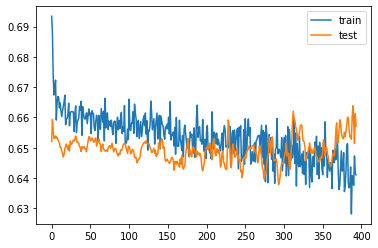

In [95]:
lag = 10
X_lstm = price_700_df_merged.drop([col for col in price_700_df_merged if '(t-' in col]+[
    'Open(t+1) >= Close', 'Open(t+1)', 'date'], axis=1).copy()
input_dim, input_col = X_lstm.shape[0], X_lstm.shape[1]

minmax = MinMaxScaler(feature_range=(0, 1))
X_lstm = minmax.fit_transform(X_lstm)
#scaler = StandardScaler()
#X_lstm = scaler.fit_transform(X_lstm)
 
X_lstm_list, y_lstm_list = [], []
for i in range(lag, len(X_lstm)):
    X_lstm_list.append(X_lstm[i-lag:i, :])
    y_lstm_list.append(np.array(price_700_df_merged['Open(t+1) >= Close'].iloc[i]))

X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(np.array(X_lstm_list)
    , np.array(y_lstm_list), test_size=.1, random_state=3, stratify=np.array(y_lstm_list))
print('X lstm train shape', X_lstm_train.shape)
print('y lstm train shape', y_lstm_train.shape)

#lstm model
lstm_model = Sequential()
# lstm_model.add(LSTM(units=64, dropout=.5, recurrent_dropout=.5, return_sequences=True))
# lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=10, dropout=.5, recurrent_dropout=.5))
# lstm_model.add(BatchNormalization())
# lstm_model.add(Dense(10, activation='elu'))
# lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=2)
history = lstm_model.fit(X_lstm_train, y_lstm_train, epochs=500, verbose=2, 
                         validation_data=[X_lstm_test, y_lstm_test], callbacks=[early_stopping], batch_size=32)

print('roc_auc in train:', roc_auc_score(y_lstm_train, lstm_model.predict(X_lstm_train)))
print('roc_auc in test:', roc_auc_score(y_lstm_test, lstm_model.predict(X_lstm_test)))

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


## Adaboost Classifier

In [137]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=1)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=0)

In [138]:
y_pred = clf.predict(X_test)

In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [140]:
confusion_matrix(y_test, y_pred)

array([[17,  7],
       [12, 25]])

In [141]:
accuracy_score(y_test, y_pred)

0.6885245901639344

In [146]:
importance_feature_df = pd.DataFrame({'col': X_train.columns, 
                                      'importance': clf.feature_importances_})

print(importance_feature_df.sort_values('importance', ascending=False).head(75))

                         col  importance
75        sp500_index_change        0.06
38             trend_adx_neg        0.04
84            bert_pca8_mean        0.03
74       nasdaq_index_change        0.03
268  sp500_index_change(t-2)        0.03
..                       ...         ...
36                 trend_adx        0.01
249          trend_psar(t-2)        0.01
198           volume_em(t-2)        0.01
323      trend_ema_fast(t-3)        0.00
327       trend_adx_neg(t-3)        0.00

[75 rows x 2 columns]


In [150]:
print('roc_auc in train:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,  1]))
print('roc_auc in test:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

roc_auc in train: 0.999971275923479
roc_auc in test: 0.6587837837837838


## SVM

In [155]:
from sklearn import svm

In [169]:
clf = svm.SVC()
clf.fit(X_train, y_train)

/home/agni-ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [170]:
y_pred = clf.predict(X_test)

In [171]:
accuracy_score(y_test, y_pred)

0.6065573770491803